In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = r"E:\TECO_Works\Conference\ISWC2022\Run_logs"              
args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
args.root_path        = r"E:\datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 50

args.learning_rate           = 0.001  
args.learning_rate_patience  = 5
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [3]:
args.seed                             = 1


args.data_name                        =  "skodar"

args.wavelet_filtering                = False
args.wavelet_filtering_regularization = False
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 6


args.difference       = False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler = False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]


if args.difference:
    args.c_in = args.c_in*2

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## 模型参数

In [4]:
args.filter_scaling_factor = 0.5
args.model_type              = "deepconvlstm"#"deepconvlstm"#"sahar" #"deepconvlstm"

In [ ]:
args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "gru"
args.temporal_info_aggregation_type = "FC"

In [ ]:
# cross_channel_interaction_type = "attn",    # attn  transformer  identity
# cross_channel_aggregation_type = "filter",  # filter  naive  FC
# temporal_info_interaction_type = "gru",     # gru  lstm  attn  transformer  identity
# temporal_info_aggregation_type = "FC",      # naive  filter  FC 

# 实验

In [5]:
# 如果我们设置为 
args.wavelet_filtering_learnable      = False
exp = Exp(args)

Use GPU: cuda:0
Build the DeepConvLSTM model!
Done!
Parameter : 278954
Set the seed as :  1


In [6]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
================ SOCV Mode ====================
================ 5 CV ======================
================ the 0 th CV Experiment ================ 
Overlapping random Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.00277778 0.00238095 0.002457   0.00337838 0.00540541 0.00558659
 0.00306748 0.00278552 0.00234192 0.00408163]
Train data number :  3204
The number of classes is :  10
The input_length  is :  84
The channel_in is :  30
Validation data number :  356
Test data number :  890
================ Build the model ================ 
Build the DeepConvLSTM model!
Epoch: 1 cost time: 3.8364243507385254
VALI: Epoch: 1, Steps: 13 | Train Loss: 2.1860892  Vali Loss: 1.8397593 Vali Accuracy: 0.3286517  Vali weighted F1: 0.2205976  Vali macro F1 0.1909406 
Validation loss decreased (inf --> 1.839759).  Saving model ...
Epoch: 2 cost ti

Epoch: 27 cost time: 2.5665855407714844
VALI: Epoch: 27, Steps: 13 | Train Loss: 0.0883586  Vali Loss: 0.0629365 Vali Accuracy: 0.9803371  Vali weighted F1: 0.9804028  Vali macro F1 0.9674556 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 28 cost time: 2.564577579498291
VALI: Epoch: 28, Steps: 13 | Train Loss: 0.0786421  Vali Loss: 0.0557866 Vali Accuracy: 0.9831461  Vali weighted F1: 0.9832948  Vali macro F1 0.9673529 
new best score!!!!
Validation loss decreased (0.061802 --> 0.055787).  Saving model ...
new best score!!!!
Epoch: 29 cost time: 2.564577341079712
VALI: Epoch: 29, Steps: 13 | Train Loss: 0.0791863  Vali Loss: 0.0487302 Vali Accuracy: 0.9943820  Vali weighted F1: 0.9943035  Vali macro F1 0.9885093 
new best score!!!!
Validation loss decreased (0.055787 --> 0.048730).  Saving model ...
new best score!!!!
Epoch: 30 cost time: 2.5665688514709473
VALI: Epoch: 30, Steps: 13 | Train Loss: 0.0744658  Vali Loss: 0.0609484 Vali Accuracy: 0.

new best score!!!!
Epoch: 4 cost time: 2.580580472946167
VALI: Epoch: 4, Steps: 13 | Train Loss: 0.8362544  Vali Loss: 0.6465110 Vali Accuracy: 0.8174157  Vali weighted F1: 0.7991961  Vali macro F1 0.7485236 
new best score!!!!
Validation loss decreased (0.894702 --> 0.646511).  Saving model ...
new best score!!!!
Epoch: 5 cost time: 2.582530975341797
VALI: Epoch: 5, Steps: 13 | Train Loss: 0.6412677  Vali Loss: 0.5017355 Vali Accuracy: 0.8483146  Vali weighted F1: 0.8352989  Vali macro F1 0.7909567 
new best score!!!!
Validation loss decreased (0.646511 --> 0.501736).  Saving model ...
new best score!!!!
Epoch: 6 cost time: 2.5845742225646973
VALI: Epoch: 6, Steps: 13 | Train Loss: 0.5160736  Vali Loss: 0.4072126 Vali Accuracy: 0.8848315  Vali weighted F1: 0.8836485  Vali macro F1 0.8544891 
new best score!!!!
Validation loss decreased (0.501736 --> 0.407213).  Saving model ...
new best score!!!!
Epoch: 7 cost time: 2.5865819454193115
VALI: Epoch: 7, Steps: 13 | Train Loss: 0.4276522 

Epoch: 32 cost time: 2.5815823078155518
VALI: Epoch: 32, Steps: 13 | Train Loss: 0.0617963  Vali Loss: 0.0404015 Vali Accuracy: 0.9887640  Vali weighted F1: 0.9887640  Vali macro F1 0.9775758 
new best score!!!!
Validation loss decreased (0.050086 --> 0.040402).  Saving model ...
new best score!!!!
Epoch: 33 cost time: 2.5805811882019043
VALI: Epoch: 33, Steps: 13 | Train Loss: 0.0563728  Vali Loss: 0.0553559 Vali Accuracy: 0.9719101  Vali weighted F1: 0.9725731  Vali macro F1 0.9507711 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 34 cost time: 2.632067918777466
VALI: Epoch: 34, Steps: 13 | Train Loss: 0.0570290  Vali Loss: 0.0344420 Vali Accuracy: 0.9887640  Vali weighted F1: 0.9887121  Vali macro F1 0.9808143 
new best score!!!!
Validation loss decreased (0.040402 --> 0.034442).  Saving model ...
new best score!!!!
Epoch: 35 cost time: 2.6804444789886475
VALI: Epoch: 35, Steps: 13 | Train Loss: 0.0542646  Vali Loss: 0.0496385 Vali Accuracy: 0

new best score!!!!
Epoch: 9 cost time: 2.6115872859954834
VALI: Epoch: 9, Steps: 13 | Train Loss: 0.2988771  Vali Loss: 0.2355588 Vali Accuracy: 0.9101124  Vali weighted F1: 0.9081549  Vali macro F1 0.8733461 
new best score!!!!
Validation loss decreased (0.283642 --> 0.235559).  Saving model ...
new best score!!!!
Epoch: 10 cost time: 2.612588882446289
VALI: Epoch: 10, Steps: 13 | Train Loss: 0.2558935  Vali Loss: 0.2001761 Vali Accuracy: 0.9410112  Vali weighted F1: 0.9416443  Vali macro F1 0.9105938 
new best score!!!!
Validation loss decreased (0.235559 --> 0.200176).  Saving model ...
new best score!!!!
Epoch: 11 cost time: 2.619598627090454
VALI: Epoch: 11, Steps: 13 | Train Loss: 0.2249478  Vali Loss: 0.1764086 Vali Accuracy: 0.9494382  Vali weighted F1: 0.9493773  Vali macro F1 0.9171887 
new best score!!!!
Validation loss decreased (0.200176 --> 0.176409).  Saving model ...
new best score!!!!
Epoch: 12 cost time: 2.6055870056152344
VALI: Epoch: 12, Steps: 13 | Train Loss: 0.20

new best score!!!!
Validation loss decreased (0.038097 --> 0.036017).  Saving model ...
new best score!!!!
Epoch: 38 cost time: 2.6115882396698
VALI: Epoch: 38, Steps: 13 | Train Loss: 0.0472189  Vali Loss: 0.0356419 Vali Accuracy: 0.9887640  Vali weighted F1: 0.9887152  Vali macro F1 0.9803752 
new best score!!!!
Validation loss decreased (0.036017 --> 0.035642).  Saving model ...
new best score!!!!
Epoch: 39 cost time: 2.612680673599243
VALI: Epoch: 39, Steps: 13 | Train Loss: 0.0417751  Vali Loss: 0.0310334 Vali Accuracy: 0.9915730  Vali weighted F1: 0.9915214  Vali macro F1 0.9829885 
new best score!!!!
Validation loss decreased (0.035642 --> 0.031033).  Saving model ...
new best score!!!!
Epoch: 40 cost time: 2.604586362838745
VALI: Epoch: 40, Steps: 13 | Train Loss: 0.0410452  Vali Loss: 0.0322433 Vali Accuracy: 0.9887640  Vali weighted F1: 0.9887121  Vali macro F1 0.9808143 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 41 cost time: 2.611

new best score!!!!
Epoch: 14 cost time: 2.610433578491211
VALI: Epoch: 14, Steps: 13 | Train Loss: 0.1699805  Vali Loss: 0.1125563 Vali Accuracy: 0.9803371  Vali weighted F1: 0.9803353  Vali macro F1 0.9640835 
new best score!!!!
Validation loss decreased (0.132772 --> 0.112556).  Saving model ...
new best score!!!!
Epoch: 15 cost time: 2.617994785308838
VALI: Epoch: 15, Steps: 13 | Train Loss: 0.1603438  Vali Loss: 0.1105707 Vali Accuracy: 0.9691011  Vali weighted F1: 0.9685748  Vali macro F1 0.9493486 
new best score!!!!
Validation loss decreased (0.112556 --> 0.110571).  Saving model ...
new best score!!!!
Epoch: 16 cost time: 2.639600992202759
VALI: Epoch: 16, Steps: 13 | Train Loss: 0.1398638  Vali Loss: 0.0979809 Vali Accuracy: 0.9719101  Vali weighted F1: 0.9719083  Vali macro F1 0.9506975 
new best score!!!!
Validation loss decreased (0.110571 --> 0.097981).  Saving model ...
new best score!!!!
Epoch: 17 cost time: 2.6215898990631104
VALI: Epoch: 17, Steps: 13 | Train Loss: 0.1

new best score!!!!
Epoch: 43 cost time: 2.635594129562378
VALI: Epoch: 43, Steps: 13 | Train Loss: 0.0337085  Vali Loss: 0.0425967 Vali Accuracy: 0.9859551  Vali weighted F1: 0.9860395  Vali macro F1 0.9771117 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 44 cost time: 2.6165976524353027
VALI: Epoch: 44, Steps: 13 | Train Loss: 0.0325410  Vali Loss: 0.0302811 Vali Accuracy: 0.9887640  Vali weighted F1: 0.9887152  Vali macro F1 0.9803752 
new best score!!!!
Validation loss decreased (0.032142 --> 0.030281).  Saving model ...
new best score!!!!
Epoch: 45 cost time: 2.6225905418395996
VALI: Epoch: 45, Steps: 13 | Train Loss: 0.0331949  Vali Loss: 0.0401270 Vali Accuracy: 0.9831461  Vali weighted F1: 0.9832302  Vali macro F1 0.9749375 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 46 cost time: 2.6225903034210205
VALI: Epoch: 46, Steps: 13 | Train Loss: 0.0314941  Vali Loss: 0.0324280 Vali Accuracy: 0.9859551 

new best score!!!!
Epoch: 19 cost time: 2.610783100128174
VALI: Epoch: 19, Steps: 13 | Train Loss: 0.1194194  Vali Loss: 0.0869843 Vali Accuracy: 0.9691011  Vali weighted F1: 0.9683566  Vali macro F1 0.9395988 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 20 cost time: 2.603600025177002
VALI: Epoch: 20, Steps: 13 | Train Loss: 0.1085432  Vali Loss: 0.0722210 Vali Accuracy: 0.9747191  Vali weighted F1: 0.9722682  Vali macro F1 0.9397120 
new best score!!!!
Validation loss decreased (0.084947 --> 0.072221).  Saving model ...
new best score!!!!
Epoch: 21 cost time: 2.699608087539673
VALI: Epoch: 21, Steps: 13 | Train Loss: 0.1078767  Vali Loss: 0.0709233 Vali Accuracy: 0.9803371  Vali weighted F1: 0.9797759  Vali macro F1 0.9578938 
new best score!!!!
Validation loss decreased (0.072221 --> 0.070923).  Saving model ...
new best score!!!!


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-21de09e58c74>", line 1, in <module>
    exp.train()
  File "../..\experiment.py", line 280, in train
    for i, (batch_x1,batch_x2,batch_y) in enumerate(train_loader):
  File "D:\anaconda\lib\site-packages\torch\utils\data\dataloader.py", line 521, in __next__
    data = self._next_data()
  File "D:\anaconda\lib\site-packages\torch\utils\data\dataloader.py", line 561, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "D:\anaconda\lib\site-packages\torch\utils\data\_utils\fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "D:\anaconda\lib\site-packages\torch\utils\data\_utils\collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "D:\anaconda\lib\site-packages\tor

TypeError: object of type 'NoneType' has no len()

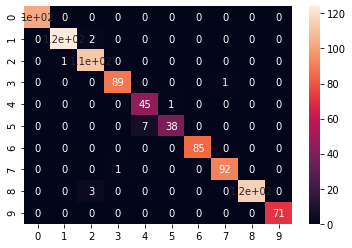

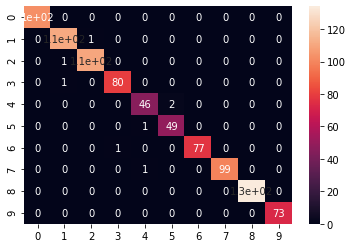

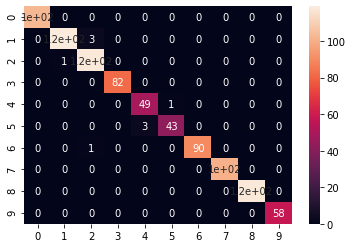

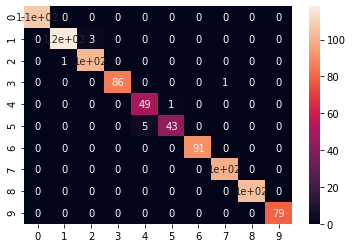

In [7]:
exp.train()

In [ ]:
dataset = data_dict[args.data_name](args)

In [ ]:
import numpy as np

In [ ]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

In [ ]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [ ]:
out.shape

In [ ]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [ ]:
for n,p in exp.model.named_parameters():
    print(n)

In [ ]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [ ]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)